In [6]:
using JLD
using SparseArrays
using LinearAlgebra
using PyCall
using TensorOperations
using FFTW
using DifferentialEquations
using SpecialFunctions
using MKL
using QuadGK
using Plots 
gspec=pyimport("matplotlib.gridspec")
patches=pyimport("matplotlib.patches")
mpimg=pyimport("matplotlib.image")

include("./src/twm_simulate.jl")

simulate_twm (generic function with 1 method)

In [7]:
BLAS.set_num_threads(5)
println(BLAS.get_config())
println(Threads.nthreads())

LBTConfig()
10


In [8]:
function gaussian_SH_pulse(zlist,σ)
    vect = [exp(-(z/σ)^2/2) for z in zlist]
    vect ./= norm(vect)
    return vect
end

gaussian_SH_pulse (generic function with 1 method)

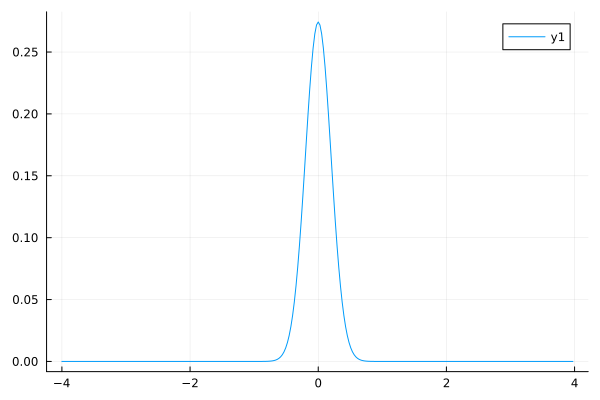

In [14]:
L = 8.0   # Size of the system. Open boundary condition.
n_half = 300   # Number of spatial bins per band. Total size of the MPS will be 2 times this number, because we have both signal and pump modes.
n_l = n_half*2   # Total number of spatial bins.
Δz = L/n_half   # Size of spatial bins
klist = [2*pi*l/L for l in -floor(Int64,n_half/2):1:ceil(Int64,n_half/2)-1]   # Wavespace coordinate
zlist = collect(range(-L/2,stop=L/2-Δz,length=n_half));   # Spatial coordinate
    
mmax = 4   # Maximum Fock space cutoff. 4 is usually enough.
n_fock = 4   # Fock space cutoff
χ = 20   # MPS bond dimension. Depends on the simulation.

β = 2   # GVD for the pump mode, relative to the signal GVD.
J = 1/(2*Δz^2)/(4pi^2)   # Nearnest-neighbor interactions between spatial bins. The value is proportionla to signal GVD.
V = 1/sqrt(Δz)   # Nonlinear coupling between local signal and pump bins.
Δ = 1.9   # Phase-mismatch between signal and pump

n_b = 0.02   # Number of pump photons
σ = 0.2   # Pump width in the temporal domain

flist = gaussian_SH_pulse(zlist,σ)   # Pump field distribution

F0 = maximum(flist)

flist_a = [i%2==1 ? flist[round(Int64,(i+1)/2)] : 0.0im for i in 1:n_l]
flist_a ./= norm(flist_a)
flist_b = [i%2==0 ? flist[round(Int64,(i)/2)] : 0.0im for i in 1:n_l]
flist_b ./= norm(flist_b)
α_a = 0.0
α_b = sqrt(n_b)

αlist_tot = α_a*flist_a+α_b*flist_b
plot(zlist,flist)

In [1]:
Γlist,λlist = coherent_twm(α_a,α_b,flist_a,flist_b,n_l,χ,mmax);

UndefVarError: UndefVarError: `coherent_twm` not defined

In [11]:
# tmax = 0 #STUPID RUN
# nt = 1 # Steps
# saveat = [1] #Doesnt work with 1:10?
# th = 1e-10 # Truncation for SVD

# Γset,λset,norm_list = simulate_twm!(Γlist,λlist,J,β,V,Δ,tmax,nt,saveat;threshold=th);

# g1set_b0 = [[g1(Γset[si],λset[si],ci) for ci in 2:2:n_l] for si in eachindex(saveat)];

In [12]:
tmax = 2.5
nt = 250 # Steps
saveat = [i for i in 1:4:nt] #Doesnt work with 1:10?
th = 1e-10 # Truncation for SVD

@time Γset,λset,norm_list = simulate_twm!(Γlist,λlist,J,β,V,Δ,tmax,nt,saveat;threshold=th);

1
  7.189478 seconds (11.49 M allocations: 2.748 GiB, 7.82% gc time, 821.29% compilation time)
  0.801676 seconds (2.28 M allocations: 2.124 GiB, 33.55% gc time, 18.70% compilation time)
2
  0.726487 seconds (2.59 M allocations: 2.131 GiB, 26.25% gc time)
  0.739022 seconds (2.88 M allocations: 2.138 GiB, 26.46% gc time)
3
  0.760930 seconds (3.00 M allocations: 2.141 GiB, 23.23% gc time)
  0.807957 seconds (3.11 M allocations: 2.144 GiB, 29.59% gc time)
4
  0.717243 seconds (3.18 M allocations: 2.146 GiB, 24.62% gc time)
  0.754020 seconds (3.27 M allocations: 2.148 GiB, 27.36% gc time)
5
  0.693705 seconds (3.33 M allocations: 2.149 GiB, 21.19% gc time)
  0.763508 seconds (3.41 M allocations: 2.151 GiB, 28.49% gc time)
6
  1.127540 seconds (3.45 M allocations: 2.152 GiB, 21.38% gc time)
  1.257349 seconds (3.52 M allocations: 2.154 GiB, 22.47% gc time)
7
  1.170386 seconds (3.56 M allocations: 2.155 GiB, 18.23% gc time)
  1.228343 seconds (3.62 M allocations: 2.157 GiB, 22.46% gc tim

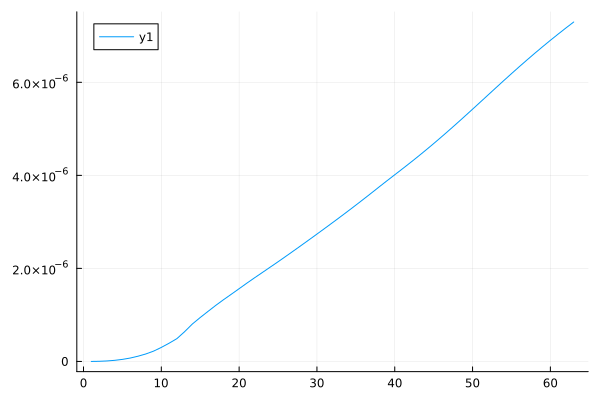

In [13]:
plot(1 .- norm_list) 

In [9]:
αset_a = [[mean(Γset[si],λset[si],ci) for ci in 1:2:n_l] for si in eachindex(saveat)]
αset_b = [[mean(Γset[si],λset[si],ci) for ci in 2:2:n_l] for si in eachindex(saveat)]
g1set_a = [[g1(Γset[si],λset[si],ci) for ci in 1:2:n_l] for si in eachindex(saveat)]
g1set_b = [[g1(Γset[si],λset[si],ci) for ci in 2:2:n_l] for si in eachindex(saveat)];
#g1set_b0 = [g1(Γlist,λlist,ci) for ci in 2:2:n_l];

63-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 +

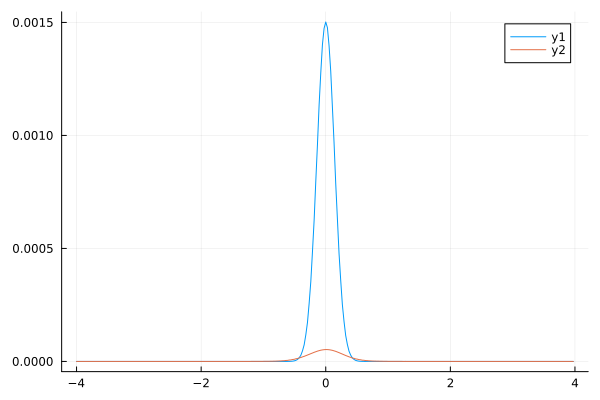

In [10]:
# PLOTN = 10
# plot(zlist,real(g1set_b[1:PLOTN]),label=[i for i in 1:PLOTN]')
# plot!(zlist,real(g1set_a[1:PLOTN]),label=["signal $i" for j in 1:1, i in 1:PLOTN])
plot(zlist, real(g1set_b[1]))
plot!(zlist, real(g1set_b[end]))

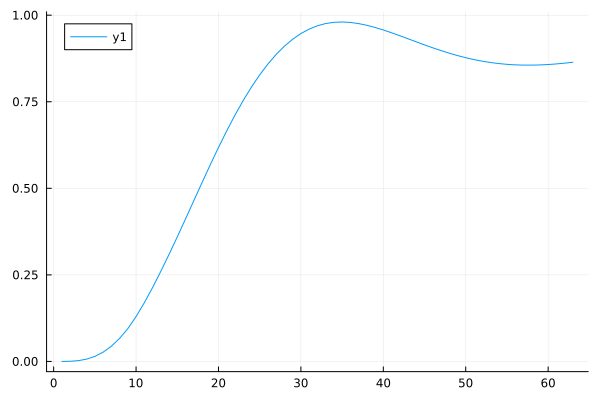

In [15]:
using Trapz
ts = range(0,tmax, nt)
efficiency = [trapz(zlist, real(g1set_a[i])) for i in 1:length(saveat)]/trapz(zlist, real(g1set_b0[1]))/2
plot(efficiency.^2)